# Reiterating our Problem Statement

**Context**: The COVID-19 pandemic has taken a toll on most people and it has resulted in a huge increase in mental health awareness.

**Problem Statement**: We are a group of data scientists representing a yoga studio. We note that there are notable differences between yoga (Physical and mental exercise) and mediation (Pursuit of mental stability). Given the increased awareness of the importance of mental health, we see an opportunity to increase and broaden our customer base. Hence, there is a need to tailor our marketing campaigns to promote yoga as a coping strategy / self-care tool. We would also like to maximise the effectiveness of our campaigns (Maximising true positives).

Our approach is detailed below:
* Grouping posts from reddit r\yoga and r\Meditation (which are similar in nature)
* Discover 'trending* words for both subreddits
* Exploring the similarities, but also focusing on exploiting differences between both subgroups
* Build an effective *classification* model to better target yoga enthusiasts (aka. r/yoga users; Maximise marketing spend)
* We can also exploit similarities between both subgroups to convert people interested in meditation to try out yoga

# Pre-processing and Modelling

Our approach is summarised below:
* Splitting / sampling data for validation and training purposes (Ensuring samples are stratified)
* Convert text data to a matrix
* We will test / evaluate a variety of models to identify a production algorithm with CountVectorizer or TFIDFVectorizer overlays
    * Logistic Regression
    * Naive Bayes
    * Random Forests
* Explaining how our chosen models work and highlight a particular model's pros/cons
* Comparing models to the baseline score and explain the evaluation metrics we have chosen to focus on
* Diving deeper into our final recommendations and addressing our original problem statement

We will build our models using a pipeline and utilise GridSearchCV to determine the best parameters. We will also be logging the total time needed to iterate our models

In [1]:
# Import necessary libraries
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import redditcleaner
import gensim

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier

import warnings
warnings.filterwarnings('ignore') # Ensuring the notebook remains tidy

In [2]:
# Read cleaned messages from our previous module
messages = pd.read_csv('../data/cleaned_messages.csv', na_values='str', index_col=[0])

In [3]:
# We will need to drop any missing rows (just as a precaution)
messages = messages.dropna()

# Let's take a quick look at our dataset; Recall: We started out with 2 sets of 1500x posts from both subreddits
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 3 to 2997
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        1696 non-null   int64 
 1   combined         1696 non-null   object
 2   selftext_lem     1696 non-null   object
 3   selftext_gensim  1696 non-null   object
dtypes: int64(1), object(3)
memory usage: 66.2+ KB


In [4]:
# Defining our variables
X = messages['selftext_gensim'] # Text has been lemmatized and cleaned
y = messages['subreddit']

In [5]:
# Do we need to stratify our train/test splits?
y.value_counts(normalize = True)

0    0.584316
1    0.415684
Name: subreddit, dtype: float64

In [6]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [7]:
print(X_train.iloc[0]) # Previewing a full sentence
X_train.head()

yoga flow w/ downward dog forward fold point online videos/routines flow avoid positions? pt need avoid bulge disc weightlifting. i'd prefer flow like yin yoga possible, routine variety. thanks!


266     yoga flow w/ downward dog forward fold point o...
2865    important pre-meditation warm ? abdominal brea...
467     men's pant yoga running? hello. seek advice re...
2659    day meditate irritated i'm happy ? it's year m...
845     yoga virgin i'm male san antonio texas,eager t...
Name: selftext_gensim, dtype: object

In [8]:
# Set seaborn style
sns.set_style(style='darkgrid')
sns.set(font_scale=1.1)

**What is the difference between CountVectorizer and TFIDFVectorizer?**

TFIDF: It stands for Term Frequency - Inverse Document Frequency and it is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.

The goal of using TF-IDF instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

## Start of Workflow

### Logistic Regression

Logistic Regression is a classification technique that is commonly used in machine learning. It utilises a logistic function to model the dependent variable (whether a subreddit falls under r/yoga or not). 

**Advantages:**
* Easy to implement, interpret and very efficient to train
* It performs well when the dataset is linearly separable
* It can interpret model coefficients as indicators of feature importance

**Disadvanages:**
* It constructs linear boundaries which means that independent variables need to be linearly related to the log-odds
* Assumption of linearity between the dependent variable and the independent variables
* More powerful and compact algorithms can easily outperform this algorithm

### Logistic Regression with Count Vectorizer

After multiple iterations of different models, we have realised that we will need to define custom stop-words to help optimise the model.

In [9]:
# Creation of custom stop-words
custom_stopwords = ['english', 'yoga', 'meditation', 've', 'it', 'wa', 'like', 'ha', 
                    'meditating', 'meditator', 'meditative', 'meditate', 'don', 'amp', 'nan']

In [10]:
# Set-up pipeline for CVEC
pipe_logr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegression())
])

In [11]:
# Obtain parameter keys
#sorted(pipe_logr_cvec.get_params().keys())

In [12]:
# Set up parameters specific to CVEC and logistic regression
logr_cvec_params = {
    'cvec__stop_words': [custom_stopwords],
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'logr__max_iter': [100, 200]
}

In [13]:
# Initialize GridSearchCV
gs_logr_cvec = GridSearchCV(pipe_logr_cvec, param_grid = logr_cvec_params, cv=5, verbose=1)

In [14]:
%%time

# Fit model
gs_logr_cvec.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 1min 27s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['english', 'yoga', 'meditation',
                                               've', 'it', 'wa', 'like', 'ha',
                                               'meditating', 'meditator',
                                               'meditative', 'meditate', 'don',
                                               'amp', 'nan']],
                         'logr__max_iter': [100, 200]},
             verbose=1)

In [15]:
# Obtaining our best model
print(gs_logr_cvec.best_score_)

# Finding out the best parameters
gs_logr_cvec.best_params_

0.8553744017291957


{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ['english',
  'yoga',
  'meditation',
  've',
  'it',
  'wa',
  'like',
  'ha',
  'meditating',
  'meditator',
  'meditative',
  'meditate',
  'don',
  'amp',
  'nan'],
 'logr__max_iter': 100}

In [16]:
# Scoring against our train split
logr_cvec_accuracy_tr = np.round(gs_logr_cvec.score(X_train, y_train), 4)
logr_cvec_accuracy_tr

0.9945

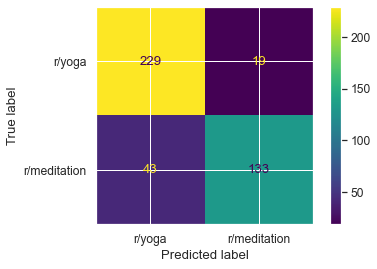

In [17]:
# Generating predictions for our test data
gs_logr_cvec_preds = gs_logr_cvec.predict(X_test)

# Creating a confusion matrix
gs_logr_cvec_cm = confusion_matrix(y_test, gs_logr_cvec_preds)
ConfusionMatrixDisplay(confusion_matrix = gs_logr_cvec_cm, display_labels=['r/yoga', 'r/meditation']).plot();

In [18]:
# Scoring against our test data
logr_cvec_accuracy = np.round(gs_logr_cvec.score(X_test, y_test), 4)
logr_cvec_accuracy

0.8538

**Note:** Just based on accuracy alone, we are seeing significant overfit in the training model.

In [19]:
# Obtain Precision score
logr_cvec_precision = np.round(precision_score(y_test, gs_logr_cvec.predict(X_test)), 4)
logr_cvec_precision

0.875

In [20]:
# Obtain Recall score
logr_cvec_recall = np.round(recall_score(y_test, gs_logr_cvec.predict(X_test)), 4)
logr_cvec_recall

0.7557

In [21]:
# Obtain F1 score
logr_cvec_f1 = np.round(f1_score(y_test, gs_logr_cvec.predict(X_test)), 4)
logr_cvec_f1

0.811

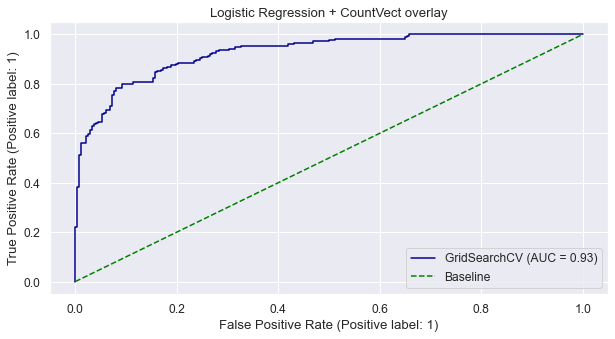

In [22]:
# Let's plot our ROC curve
plt.rcParams["figure.figsize"] = (10,5)

plot_roc_curve(gs_logr_cvec, X_test, y_test, color="darkblue")
plt.plot([0, 1], [0, 1], label = 'Baseline', linestyle = '--', color="green")
plt.title("Logistic Regression + CountVect overlay")
plt.legend()
plt.show()

In [23]:
# Obtain area under the ROC curve
logr_cvec_roc_auc_score = np.round(roc_auc_score(y_test, gs_logr_cvec.predict_proba(X_test)[:,1]), 4)
logr_cvec_roc_auc_score

0.9275

**Logistic Regression with Tifdf**

In [24]:
# Set-up pipeline for CVEC
pipe_logr_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegression())
])

In [25]:
logr_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [custom_stopwords],
    'tvec__ngram_range': [(1,1), (1,2)],
    'logr__max_iter': [100, 200]
}

In [26]:
# Initialize GridSearchCV
gs_logr_tvec = GridSearchCV(pipe_logr_tvec, param_grid = logr_tvec_params, cv=5, verbose=1)

In [27]:
%%time

# Fit model
gs_logr_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Wall time: 15.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__max_iter': [100, 200],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [['english', 'yoga', 'meditation',
                                               've', 'it', 'wa', 'like', 'ha',
                                               'meditating', 'meditator',
                                               'meditative', 'meditate', 'don',
                                               'amp', 'nan']]},
             verbose=1)

In [28]:
print(gs_logr_tvec.best_score_)
gs_logr_tvec.best_params_

0.8703103288559518


{'logr__max_iter': 100,
 'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': ['english',
  'yoga',
  'meditation',
  've',
  'it',
  'wa',
  'like',
  'ha',
  'meditating',
  'meditator',
  'meditative',
  'meditate',
  'don',
  'amp',
  'nan']}

In [29]:
# Scoring against our train split
logr_tvec_accuracy_tr = np.round(gs_logr_tvec.score(X_train, y_train), 4)
logr_tvec_accuracy_tr

0.9513

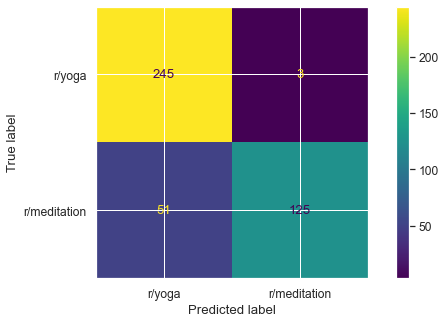

In [30]:
# Generating predictions for our test data
gs_logr_tvec_preds = gs_logr_tvec.predict(X_test)

# Creating a confusion matrix
gs_logr_tvec_cm = confusion_matrix(y_test, gs_logr_tvec_preds)
ConfusionMatrixDisplay(confusion_matrix = gs_logr_tvec_cm, display_labels=['r/yoga', 'r/meditation']).plot();

In [31]:
# Scoring against our test split
logr_tvec_accuracy = np.round(gs_logr_tvec.score(X_test, y_test), 4)
logr_tvec_accuracy

0.8726

In [32]:
# Obtain Precision score
logr_tvec_precision = np.round(precision_score(y_test, gs_logr_tvec.predict(X_test)), 4)
logr_tvec_precision

0.9766

In [33]:
# Obtain Recall score
logr_tvec_recall = np.round(recall_score(y_test, gs_logr_tvec.predict(X_test)), 4)
logr_tvec_recall

0.7102

In [34]:
# Obtain F1 score
logr_tvec_f1 = np.round(f1_score(y_test, gs_logr_tvec.predict(X_test)), 4)
logr_tvec_f1

0.8224

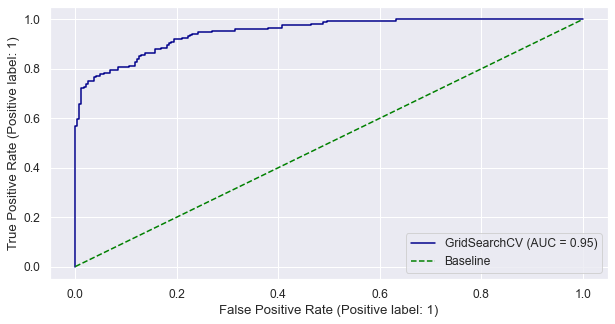

In [35]:
# Let's plot our ROC curve
plt.rcParams["figure.figsize"] = (10,5)

plot_roc_curve(gs_logr_tvec, X_test, y_test, color="darkblue")
plt.plot([0, 1], [0, 1], label = 'Baseline', linestyle = '--', color="green")
plt.legend()
plt.show()

In [36]:
# Obtain area under the ROC curve
logr_tvec_roc_auc_score = np.round(roc_auc_score(y_test, gs_logr_tvec.predict_proba(X_test)[:,1]), 4)
logr_tvec_roc_auc_score

0.9496

### Multinomial Naive Bayes (NB)

We apply Multinomial Naive Bayes here where our variables are positive integers (after running CountVect and Tfidf). It is a supervised learning algorithm for classification so the task is to find the class of observation given the values of features.

**Advantages**:
* The assumption that all features are independent makes naive bayes algorithm very fast compared to complicated algorithms. Speed is preferred over higher accuracy (Low computation cost)
* Easy to implement; Able to effectively work with large datasets
* It works well with high-dimensional data such as text classification, email spam detection

**Disadvantages**:
* The assumption that all features are independent is not the case in real life so it makes naive bayes algorithm less accurate than complicated algorithms
* While our classifications are accurate, our predicted probabilities are usually quite bad

**Multinomial Naive Bayes with Count Vectorizer**

In [37]:
# Set-up pipeline for CVEC
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [38]:
# Obtain parameter keys
#sorted(pipe_nb_cvec.get_params().keys())

In [39]:
# Set up parameters specific to CVEC
nb_cvec_params = {
    'cvec__stop_words': [custom_stopwords],
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.9, 1]
}

In [40]:
# Initialize GridSearchCV
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, param_grid = nb_cvec_params, cv=5, verbose=1)

In [41]:
%%time
gs_nb_cvec.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 1min 11s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['english', 'yoga', 'meditation',
                                               've', 'it', 'wa', 'like', 'ha',
                                               'meditating', 'meditator',
                                               'meditative', 'meditate', 'don',
                                               'amp', 'nan']],
                         'nb__alpha': [0.9, 1]},
             verbose=1)

In [42]:
# Determining our best model score and parameters
print(gs_nb_cvec.best_score_)
gs_nb_cvec.best_params_

0.874216458236838


{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['english',
  'yoga',
  'meditation',
  've',
  'it',
  'wa',
  'like',
  'ha',
  'meditating',
  'meditator',
  'meditative',
  'meditate',
  'don',
  'amp',
  'nan'],
 'nb__alpha': 0.9}

In [43]:
# Scoring our train split
nb_cvec_accuracy_tr = np.round(gs_nb_cvec.score(X_train, y_train), 4)
nb_cvec_accuracy_tr

0.941

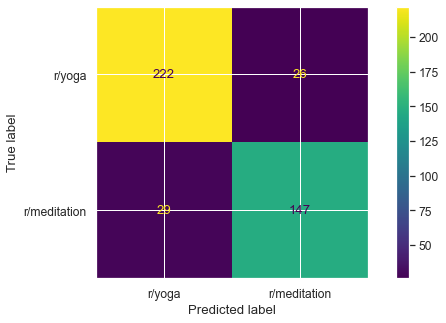

In [44]:
# Generating predictions for our test data
gs_nb_cvec_preds = gs_nb_cvec.predict(X_test)

# Creating a confusion matrix
gs_nb_cvec_cm = confusion_matrix(y_test, gs_nb_cvec_preds)
ConfusionMatrixDisplay(confusion_matrix = gs_nb_cvec_cm, display_labels=['r/yoga', 'r/meditation']).plot();

In [45]:
# Scoring our test split
nb_cvec_accuracy = np.round(gs_nb_cvec.score(X_test, y_test), 4)
nb_cvec_accuracy

0.8703

In [46]:
# Obtain Precision score
nb_cvec_precision = np.round(precision_score(y_test, gs_nb_cvec.predict(X_test)), 4)
nb_cvec_precision

0.8497

In [47]:
# Obtain Recall score
nb_cvec_recall = np.round(recall_score(y_test, gs_nb_cvec.predict(X_test)), 4)
nb_cvec_recall

0.8352

In [48]:
# Obtain F1 score
nb_cvec_f1 = np.round(f1_score(y_test, gs_nb_cvec.predict(X_test)), 4)
nb_cvec_f1

0.8424

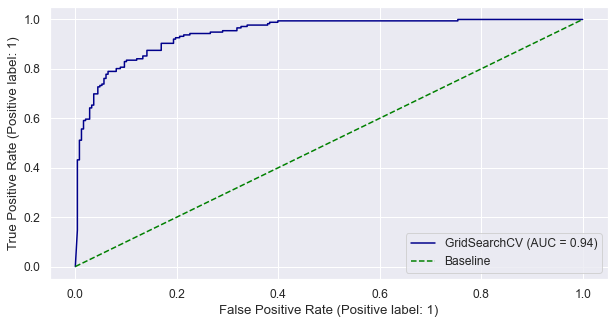

In [49]:
# Let's plot our ROC curve
plot_roc_curve(gs_nb_cvec, X_test, y_test, color="darkblue")
plt.plot([0, 1], [0, 1], label = 'Baseline', linestyle = '--', color="green")
plt.legend()
plt.show()

In [50]:
# Obtain area under the ROC curve
nb_cvec_roc_auc_score = np.round(roc_auc_score(y_test, gs_nb_cvec.predict_proba(X_test)[:,1]), 4)
nb_cvec_roc_auc_score

0.9446

**Multinomial Naive Bayes with TfidfVectorizer**

In [51]:
# Set-up pipeline for tf-idf vectorizer
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [52]:
nb_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [custom_stopwords],
    'tvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.9, 1]
}

In [53]:
# Instantiate GridSearchCV.
gs_nb_tvec = GridSearchCV(pipe_nb_tvec, param_grid = nb_tvec_params, cv=5, verbose=1)

In [54]:
%%time

# Fit our model
gs_nb_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Wall time: 12.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.9, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [['english', 'yoga', 'meditation',
                                               've', 'it', 'wa', 'like', 'ha',
                                               'meditating', 'meditator',
                                               'meditative', 'meditate', 'don',
                                               'amp', 'nan']]},
             verbose=1)

In [55]:
# Find out our best score and parameters
print(gs_nb_tvec.best_score_)
gs_nb_tvec.best_params_

0.8648077813802686


{'nb__alpha': 0.9,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': ['english',
  'yoga',
  'meditation',
  've',
  'it',
  'wa',
  'like',
  'ha',
  'meditating',
  'meditator',
  'meditative',
  'meditate',
  'don',
  'amp',
  'nan']}

In [56]:
# Score model on our train split
nb_tvec_accuracy_tr = np.round(gs_nb_tvec.score(X_train, y_train), 4)
nb_tvec_accuracy_tr

0.9237

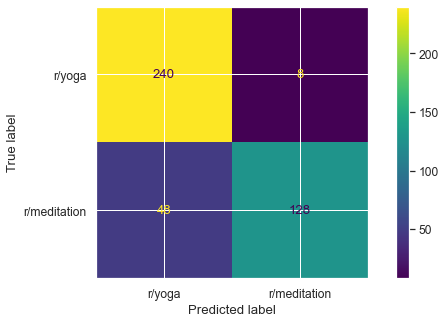

In [57]:
# Generating predictions for our test data
gs_nb_tvec_preds = gs_nb_tvec.predict(X_test)

# Creating a confusion matrix
gs_nb_tvec_cm = confusion_matrix(y_test, gs_nb_tvec_preds)
ConfusionMatrixDisplay(confusion_matrix = gs_nb_tvec_cm, display_labels=['r/yoga', 'r/meditation']).plot();

In [58]:
# Score model on test split
nb_tvec_accuracy = np.round(gs_nb_tvec.score(X_test, y_test), 4)
nb_tvec_accuracy

0.8679

In [59]:
# Obtain Precision score
nb_tvec_precision = np.round(precision_score(y_test, gs_nb_tvec.predict(X_test)), 4)
nb_tvec_precision

0.9412

In [60]:
# Obtain Recall score
nb_tvec_recall = np.round(recall_score(y_test, gs_nb_tvec.predict(X_test)), 4)
nb_tvec_recall

0.7273

In [61]:
# Obtain F1 score
nb_tvec_f1 = np.round(f1_score(y_test, gs_nb_tvec.predict(X_test)), 4)
nb_tvec_f1

0.8205

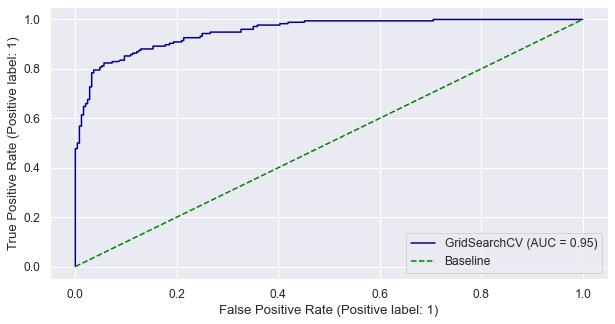

In [62]:
# Let's plot our ROC curve
plot_roc_curve(gs_nb_tvec, X_test, y_test, color="darkblue")
plt.plot([0, 1], [0, 1], label = 'Baseline', linestyle = '--', color="green")
plt.legend()
plt.show()

In [63]:
# Obtain area under the ROC curve
nb_tvec_roc_auc_score = np.round(roc_auc_score(y_test, gs_nb_tvec.predict_proba(X_test)[:,1]), 4)
nb_tvec_roc_auc_score

0.9512

### Random Forests

Random forest is a supervised learning algorithm. It builds a forest with an ensemble of decision trees. It is an easy to use machine learning algorithm that produces a great result most of the time even without hyperparameter tuning

**Advantages**:
* Random Forests implicitly perform feature selection and generate uncorrelated decision trees. It does this by choosing a random set of features to build each decision tree. This also makes it a great model when you have to work with a high number of features in the data
* Random Forests are not influenced by outliers to a fair degree. It does this by binning the variables.
* Ability in handling linear and non-linear relationships well
* Able to provide high accuracy and balance the bias-variance trade-off well. Since the model’s principle is to average the results across the multiple decision trees it builds, it averages the variance as well

**Disadvantages**:
* Random Forests are not easily interpretable. They provide feature importance but it does not provide complete visibility into the coefficients as linear regression.
* They can be computationally intensive for large datasets (Very true!)
* Random forests are like black-boxes, you have very little control over what the model does

**Random Forest with Count Vectorizer**

In [64]:
# Set-up pipeline for tf-idf vectorizer + Random forest
pipe_rfc_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [65]:
rfc_cvec_params = {
    'rfc__n_estimators': [100, 150],
    'rfc__max_depth': [None, 1, 2],
    'cvec__stop_words': [custom_stopwords],
    'cvec__max_features': [2000, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
}

In [66]:
# Instantiate GridSearchCV.
gs_rfc_cvec = GridSearchCV(pipe_rfc_cvec, param_grid = rfc_cvec_params, cv=5, verbose=1)

In [67]:
%%time

# Fit our model
gs_rfc_cvec.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 3min 24s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['english', 'yoga', 'meditation',
                                               've', 'it', 'wa', 'like', 'ha',
                                               'meditating', 'meditator',
                                               'meditative', 'meditate', 'don',
                                               'amp', 'nan']],
                         'rfc__max_depth': [None, 1, 2],
                         'rfc__n_estimators': [100, 150]},
             verbose=1)

In [68]:
# Find out our best model and parameters
print(gs_rfc_cvec.best_score_)
gs_rfc_cvec.best_params_

0.8609016519993824


{'cvec__max_df': 0.95,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ['english',
  'yoga',
  'meditation',
  've',
  'it',
  'wa',
  'like',
  'ha',
  'meditating',
  'meditator',
  'meditative',
  'meditate',
  'don',
  'amp',
  'nan'],
 'rfc__max_depth': None,
 'rfc__n_estimators': 150}

In [69]:
# Scoring our train split
rfc_cvec_accuracy_tr = np.round(gs_rfc_cvec.score(X_train, y_train), 4)
rfc_cvec_accuracy_tr

1.0

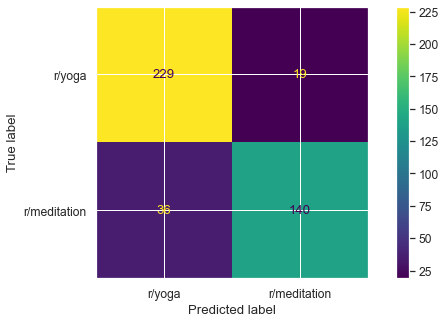

In [70]:
# Generating predictions for our test data
gs_rfc_cvec_preds = gs_rfc_cvec.predict(X_test)

# Creating a confusion matrix
gs_rfc_cvec_cm = confusion_matrix(y_test, gs_rfc_cvec_preds)
ConfusionMatrixDisplay(confusion_matrix = gs_rfc_cvec_cm, display_labels=['r/yoga', 'r/meditation']).plot();

In [71]:
# Scoring our test split
rfc_cvec_accuracy = np.round(gs_rfc_cvec.score(X_test, y_test), 4)
rfc_cvec_accuracy

0.8703

In [72]:
# Obtain Precision score
rfc_cvec_precision = np.round(precision_score(y_test, gs_rfc_cvec.predict(X_test)), 4)
rfc_cvec_precision

0.8805

In [73]:
# Obtain Recall score
rfc_cvec_recall = np.round(recall_score(y_test, gs_rfc_cvec.predict(X_test)), 4)
rfc_cvec_recall

0.7955

In [74]:
# Obtain F1 score
rfc_cvec_f1 = np.round(f1_score(y_test, gs_rfc_cvec.predict(X_test)), 4)
rfc_cvec_f1

0.8358

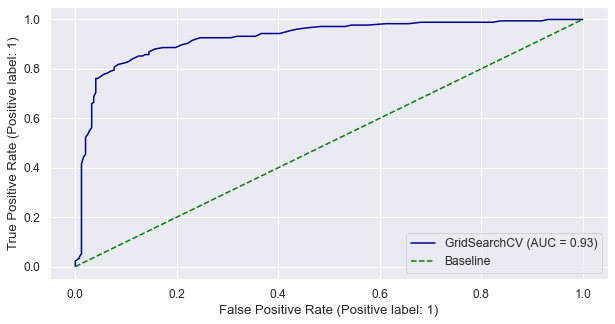

In [75]:
# Let's plot our ROC curve
plt.rcParams["figure.figsize"] = (10,5)

plot_roc_curve(gs_rfc_cvec, X_test, y_test, color="darkblue")
plt.plot([0, 1], [0, 1], label = 'Baseline', linestyle = '--', color="green")
plt.legend()
plt.show()

In [76]:
# Obtain area under the ROC curve
rfc_cvec_roc_auc_score = np.round(roc_auc_score(y_test, gs_rfc_cvec.predict_proba(X_test)[:,1]), 4)
rfc_cvec_roc_auc_score

0.9255

**Random Forest with TidfVectorizer**

In [77]:
# Set-up pipeline for tf-idf vectorizer + Random forest
pipe_rfc_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [78]:
rfc_tvec_params = {
    'rfc__n_estimators': [100, 150],
    'rfc__max_depth': [None, 1, 2],
    'tvec__max_features': [2_000, 3_000],
    'tvec__stop_words': [custom_stopwords],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [79]:
# Instantiate GridSearchCV.
gs_rfc_tvec = GridSearchCV(pipe_rfc_tvec, param_grid = rfc_tvec_params, cv=5, verbose=1)

In [80]:
%%time
gs_rfc_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 50.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [None, 1, 2],
                         'rfc__n_estimators': [100, 150],
                         'tvec__max_features': [2000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [['english', 'yoga', 'meditation',
                                               've', 'it', 'wa', 'like', 'ha',
                                               'meditating', 'meditator',
                                               'meditative', 'meditate', 'don',
                                               'amp', 'nan']]},
             verbose=1)

In [81]:
# Find out our best model and parameters
print(gs_rfc_tvec.best_score_)
gs_rfc_tvec.best_params_

0.8600771962328239


{'rfc__max_depth': None,
 'rfc__n_estimators': 100,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': ['english',
  'yoga',
  'meditation',
  've',
  'it',
  'wa',
  'like',
  'ha',
  'meditating',
  'meditator',
  'meditative',
  'meditate',
  'don',
  'amp',
  'nan']}

In [82]:
# Scoring our train split
rfc_tvec_accuracy_tr = np.round(gs_rfc_tvec.score(X_train, y_train), 4)
rfc_tvec_accuracy_tr

1.0

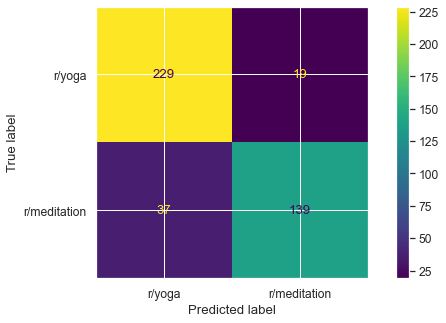

In [83]:
# Generating predictions for our test data
gs_rfc_tvec_preds = gs_rfc_tvec.predict(X_test)

# Creating a confusion matrix
gs_rfc_tvec_cm = confusion_matrix(y_test, gs_rfc_tvec_preds)
ConfusionMatrixDisplay(confusion_matrix = gs_rfc_tvec_cm, display_labels=['r/yoga', 'r/meditation']).plot();

In [84]:
# Scoring our test split (Accuracy)
rfc_tvec_accuracy = np.round(gs_rfc_tvec.score(X_test, y_test), 4)
rfc_tvec_accuracy

0.8679

In [85]:
# Scoring our test split (Precision)
rfc_tvec_precision = np.round(precision_score(y_test, gs_rfc_tvec.predict(X_test)), 4)
rfc_tvec_precision

0.8797

In [86]:
# Scoring our test split (Recall)
rfc_tvec_recall = np.round(recall_score(y_test, gs_rfc_tvec.predict(X_test)), 4)
rfc_tvec_recall

0.7898

In [87]:
# Scoring our test split (Recall)
rfc_tvec_f1 = np.round(f1_score(y_test, gs_rfc_tvec.predict(X_test)), 4)
rfc_tvec_f1

0.8323

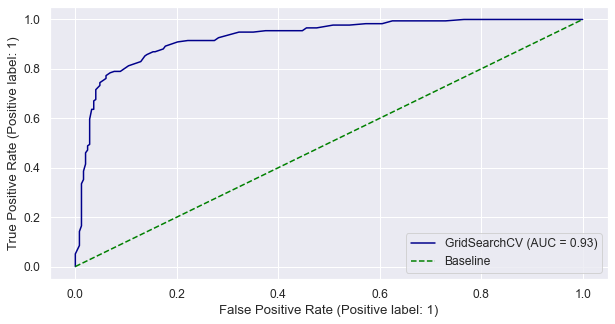

In [88]:
# Let's plot our ROC curve
plt.rcParams["figure.figsize"] = (10,5)

plot_roc_curve(gs_rfc_tvec, X_test, y_test, color="darkblue")
plt.plot([0, 1], [0, 1], label = 'Baseline', linestyle = '--', color="green")
plt.legend()
plt.show()

In [89]:
# Obtain area under ROC
rfc_tvec_roc_auc_score = np.round(roc_auc_score(y_test, gs_rfc_tvec.predict_proba(X_test)[:,1]), 4)
rfc_tvec_roc_auc_score

0.9277

# Model Evaluation

In [90]:
from prettytable import PrettyTable

In [91]:
# Creation of our pretty table
t = PrettyTable(['Model', 'Vectorizer', 'Accuracy (Train)', 'Accuracy (Test)', 
                 'Precision (Test)', 'Recall (Test)', 'F1 Score', 'ROC AUC'])

t.add_row(['Logistic Regression', 'CountVect', logr_cvec_accuracy_tr, logr_cvec_accuracy,
          logr_cvec_precision, logr_cvec_recall, logr_cvec_f1, logr_cvec_roc_auc_score])

t.add_row(['Logistic Regression', 'TFIDF', logr_tvec_accuracy_tr, logr_tvec_accuracy,
          logr_tvec_precision, logr_tvec_recall, logr_tvec_f1, logr_tvec_roc_auc_score])

t.add_row(['Naive Bayes', 'CountVect', nb_cvec_accuracy_tr, nb_cvec_accuracy,
          nb_cvec_precision, nb_cvec_recall, nb_cvec_f1, nb_cvec_roc_auc_score])

t.add_row(['Naive Bayes', 'TFIDF', nb_tvec_accuracy_tr, nb_tvec_accuracy,
          nb_tvec_precision, nb_tvec_recall, nb_tvec_f1, nb_tvec_roc_auc_score])

t.add_row(['Random Forest', 'CountVect', rfc_cvec_accuracy_tr, rfc_cvec_accuracy,
          rfc_cvec_precision, rfc_cvec_recall, rfc_cvec_f1, rfc_cvec_roc_auc_score])

t.add_row(['Random Forest', 'TFIDF', rfc_tvec_accuracy_tr, rfc_tvec_accuracy,
          rfc_tvec_precision, rfc_tvec_recall, rfc_tvec_f1, rfc_tvec_roc_auc_score])

In [92]:
# See snapshot of our model(s) below
t

Model,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score,ROC AUC
Logistic Regression,CountVect,0.9945,0.8538,0.875,0.7557,0.811,0.9275
Logistic Regression,TFIDF,0.9513,0.8726,0.9766,0.7102,0.8224,0.9496
Naive Bayes,CountVect,0.941,0.8703,0.8497,0.8352,0.8424,0.9446
Naive Bayes,TFIDF,0.9237,0.8679,0.9412,0.7273,0.8205,0.9512
Random Forest,CountVect,1.0,0.8703,0.8805,0.7955,0.8358,0.9255
Random Forest,TFIDF,1.0,0.8679,0.8797,0.7898,0.8323,0.9277


**My thought process**

Our preferred model to implement in our workflow going forward would be a Naive Bayes model with a Countvectorizer overlay. Our focus is on optimising the following metrics:

**Precision**

*Precision* gives us information about the model's performance with respect to false positives (How many did we catch?). Tying this back to our problem statement, this would mean the measure of posts we correctly classify as falling under r/yoga out of all r/yoga posts.

$$
Precision = \frac{\text{True Positive}} {(\text{True Positive} + \text{False Positive})}
$$

**Recall**

On the other hand, recall gives us information about a classifier's performance with respect to false negatives (How many did we miss?). Out of all r/yoga posts, this tells us how many we correctly identify as falling under r/yoga.

$$
Recall = \frac{\text{True Positive}} {(\text{True Positive} + \text{False Negative})}
$$


**F1 score**

The F1 score is the harmonic mean (or, simply **balance**) of both ***precision and recall***. This forces us to make a trade-off between Precision and Recall. 

$$
F1 = 2*\frac{(\text{Precision}*\text{Recall})} {(\text{Precision} + \text{Recall})}
$$



**Overall**: 

The Naive Bayes model with the CountVectorizer overlay has the best F1 score here. As our dataset is not significantly unbalanced, we do not to tweak our false positive thresholds, hence we do not need to place a lot of emphasis on the ROC AUC.

## Conclusion

Our best model appears to be a Naive Bayes + Count Vectorizer mix. We are optimising for our F1 score.

In [93]:
# Converting our model outputs into a dataframe for easier charting
nb_cvec_feat = pd.concat([pd.DataFrame(gs_nb_cvec.best_estimator_.named_steps['cvec'].get_feature_names()), 
                          pd.DataFrame(np.exp(gs_nb_cvec.best_estimator_.named_steps['nb'].feature_log_prob_[0])),
                          pd.DataFrame(np.exp(gs_nb_cvec.best_estimator_.named_steps['nb'].feature_log_prob_[1]))], axis=1)

In [94]:
# Finding our best estimators
gs_nb_cvec.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['english', 'yoga', 'meditation',
                                             've', 'it', 'wa', 'like', 'ha',
                                             'meditating', 'meditator',
                                             'meditative', 'meditate', 'don',
                                             'amp', 'nan'])),
                ('nb', MultinomialNB(alpha=0.9))])

In [95]:
# Let's create a dataframe of our features with their respective probabilities of belonging to r/mediation and r/yoga subreddits
nb_cvec_feat.columns = ['feature', 'prob_meditation', 'prob_yoga']

In [96]:
# A sneak-peak at our dataframe
nb_cvec_feat.tail(2)

,feature,prob_meditation,prob_yoga
4998,zone,0.000220,0.000066
4999,zoom,0.000064,0.000274


In [97]:
# Extracting the top 100 words from each class
top_words_meditation = nb_cvec_feat.sort_values(by=['prob_meditation'], ascending=False).head(100)
top_words_yoga = nb_cvec_feat.sort_values(by=['prob_yoga'], ascending=False)[['feature', 'prob_yoga']].head(100)

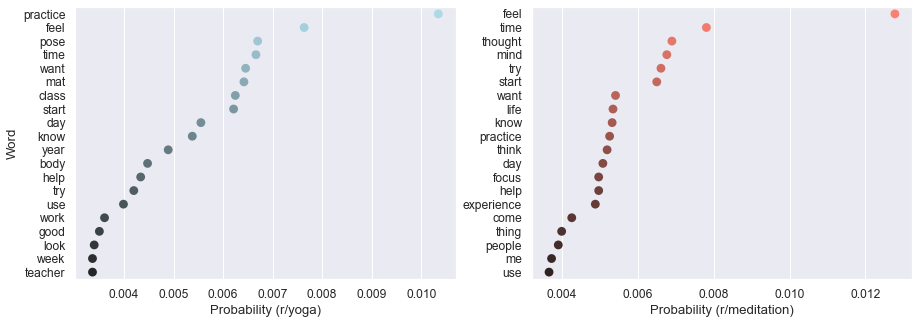

In [98]:
# Let's chart the top 10 words that offer the highest probabilities of a particular post belonging to r/yoga
sns.set_style(style="darkgrid")
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

g1 = sns.pointplot(data=top_words_yoga.head(20), ax=axs[0],
            y='feature', x='prob_yoga', palette='dark:lightblue_r')

g2 = sns.pointplot(data=top_words_meditation.head(20), ax=axs[1],
            y='feature', x='prob_meditation', palette='dark:salmon_r')

g1.set_ylabel("Word")
g2.set_ylabel("")
g1.set_xlabel("Probability (r/yoga)")
g2.set_xlabel("Probability (r/meditation)")
plt.show()

In [99]:
# Focusing on the top predictor words unique to yoga
unique_list_yoga = []
unique_list_yoga_probs = []
for word, prob in top_words_yoga[['feature', 'prob_yoga']].values:
    if word not in top_words_meditation['feature'].values:
        unique_list_yoga.append(word)
        unique_list_yoga_probs.append(prob)

In [100]:
# Creation of unique yoga predictors
top_unique_words_yoga = pd.DataFrame()
top_unique_words_yoga['feature'] = unique_list_yoga
top_unique_words_yoga['prob'] = unique_list_yoga_probs
top_unique_words_yoga['class'] = 'yoga'

In [101]:
# Focusing on the top predictor words that have considerable overlaps between yoga and meditation
overlap_list = []
overlap_list_probs = []
for word, prob in top_words_yoga[['feature', 'prob_yoga']].values:
    if word in top_words_meditation['feature'].values:
        overlap_list.append(word)
        overlap_list_probs.append(prob)

In [102]:
# Creation of predictors that overlap
top_overlap_words = pd.DataFrame()
top_overlap_words['feature'] = overlap_list
top_overlap_words['prob'] = overlap_list_probs
top_overlap_words['class'] = 'overlap'

In [103]:
# Focusing on the top predictor words unique to meditation
unique_list_medit = []
unique_list_medit_probs = []
for word, prob in top_words_meditation[['feature', 'prob_meditation']].values:
    if word not in top_words_yoga['feature'].values:
        unique_list_medit.append(word)
        unique_list_medit_probs.append(prob)

In [104]:
# Creation of unique meditation predictors
top_unique_words_medit = pd.DataFrame()
top_unique_words_medit['feature'] = unique_list_medit
top_unique_words_medit['prob'] = unique_list_medit_probs
top_unique_words_medit['class'] = 'meditation'

In [105]:
# Let's merge these datasets above
combined_predictors = pd.concat([top_unique_words_yoga.head(10), 
                                 top_unique_words_medit.head(10), 
                                 top_overlap_words.head(10)], axis=0)

combined_predictors.sort_values(by='prob', inplace=True)

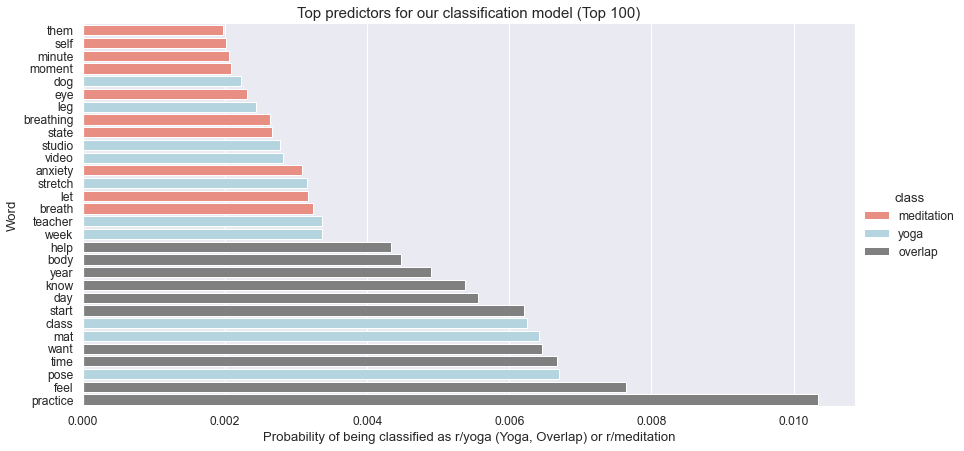

In [106]:
# Let's chart the top 10 words that offer the highest probabilities of a particular post belonging to r/yoga
sns.catplot(data=combined_predictors, y='feature', x='prob', kind='bar', 
            hue='class', dodge=False, palette=['salmon', 'lightblue', 'grey'], aspect=2, height=6)
plt.title("Top predictors for our classification model (Top 100)", size=15)
plt.ylabel('Word')
plt.xlabel('Probability of being classified as r/yoga (Yoga, Overlap) or r/meditation')
plt.show()

**Our findings**:

There are considerable overlaps in the top predictor words for r/yoga and r/meditation classifications. However, certain words stand out for r/yoga (i.e. pose, mat, class, week, teacher, studio, video).

These terms tend to be found in posts - that contain concerns and challenges faced by yoga enthusiasts (i.e. incorrect postures, beginner challenges, bodyaches after yoga, questions around various poses).

In [107]:
# Analyzing the sentiment produced by our top predictor words
sid = SentimentIntensityAnalyzer()

In [108]:
combined_predictors['VADERscores'] = combined_predictors['feature'].apply(lambda feature: sid.polarity_scores(feature))
combined_predictors['VADERcompound'] = combined_predictors['VADERscores'].apply(lambda score_dict: score_dict['compound'])

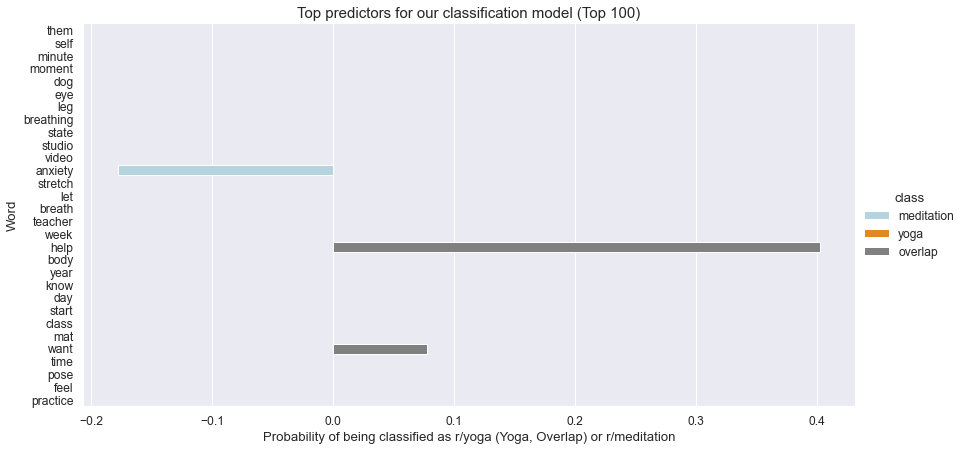

In [109]:
# Let's chart the top 10 words that offer the highest probabilities of a particular post belonging to r/yoga
sns.catplot(data=combined_predictors, y='feature', x='VADERcompound', kind='bar', 
            hue='class', dodge=False, palette=['lightblue', 'darkorange', 'grey'], aspect=2, height=6)
plt.title("Top predictors for our classification model (Top 100)", size=15)
plt.ylabel('Word')
plt.xlabel('Probability of being classified as r/yoga (Yoga, Overlap) or r/meditation')
plt.show()

**Our findings**:

Most of the top predictor words are fairly neutral. Although anxiety shows up as a negative score, we are not able to see how the word was used in a larger context. This is a limitation of our Naive Bayers model.

## Takeaways

**Recommendations**
* Our text-based classifier model is able to accurately pin-point posts that fall under r/yoga - This means that we will be able to improve efficacy of our marketing approach
* Our identification of top-words can be used to optimise the messaging of marketing content or product description
* There appears to be a demand for yoga instructional videos / online classes on a variety of poses
* Mats also appear to feature in a lot of r/yoga subreddit discussions; We could improve studio sign-up rates by throwing in a complimentary yoga mat
* There are also numerous mentions of studios / classes - Marketing materials should clearly list locations of studios and provide detailed time-tables of yoga classes

**Future Enhancements**
* We can look and identify more subreddits (i.e. Hot and top sections) to determine what is trending
* Exploring a variety of models (i.e. SVM, Gradient descent and deep learning models)
* We can run sentiment analysis on subreddit post comments
* Stop-words can be further customised to optimise our models

--- END ---